# Лабораторная работа №4. Синтез КИХ-фильтров.
Курс: лаборатория цифровой обработки сигналов, ФРКТ МФТИ
#  Модуль 2. Метод окон (window method).

## План занятий лабораторной работы №4

* Mетод частотной выборки (Frequency Sampling Method) — *занятие 1 модуль 1* 
* **Метод окон (window method)— *занятие 2 модуль 2***
* Оптимальные методы — *занятие 3 модуль 3*
* * Наименьших квадратов (least-squares error minimization)
* * Равномерной Чебышёвской аппроксимации (minimax method, Parks–McClellan filter design algorithm, Remez algorithm)

## Тестовое задание

Синтезировать КИХ-фильтр нижних частот оконным методом при заданных требованиях к АЧХ:

* частота дискретизации $f_s=2000$ Гц,
* граничная частота полосы пропускания $f_1=450$ Гц,
* граничная частота полосы задерживания $f_2=550$ Гц,
* максимально допустимое отклонение АЧХ в полосе пропускания $\delta_1=0.1$, 
* максимально допустимое отклонение АЧХ в полосе задерживания $\delta_2=0.05$.

In [1]:
fs=2000
f1=450
f2=550
delta1=0.1
delta2=0.05

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [3]:
%matplotlib notebook

In [4]:
%matplotlib inline

## КИХ-фильтры (повторение)
КИХ — конечная импульсная характеристика.

У КИХ-фильтров импульсная характеристика $h[k]$ представлена конечным набором ненулевых отсчетов $h[0]$, $h[1]$, $\dots$, $h[N-1]$. Передаточная функция $H(z)$ представлена конечным числом слагаемых. 


$H\left( z \right)={{h}[0]}+{{h}[1]}{{z}^{-1}}+...+{{h}[{N-1}]}{{z}^{-\left( N-1 \right)}}=\sum\limits_{k=0}^{N-1}{h[k]{{z}^{-k}}}$

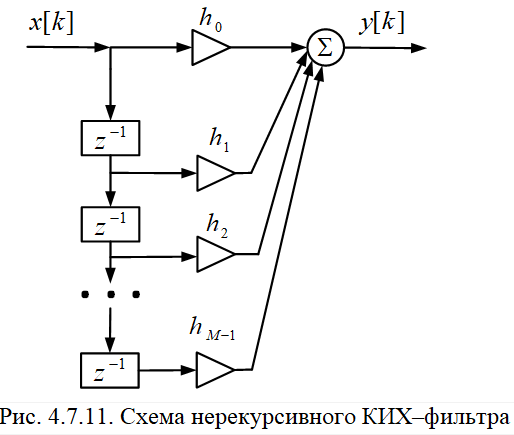


* $N$ - число ненулевых отсчетов импульсной характеристики 
* $R=N-1$ - порядок фильтра (число блоков задержки на один такт $z^{-1}$) в нерекурсивной реализации

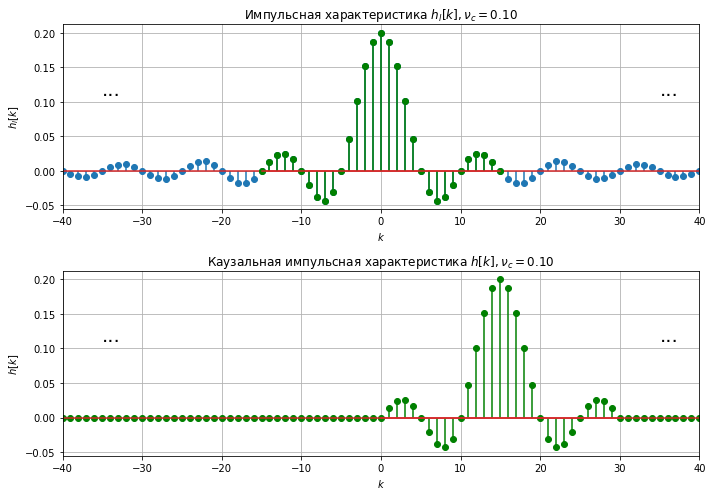

In [5]:
nu_c=0.1

plt.figure(figsize=[10, 7])

def hk_val(k, nu_c):
    if k!=0:
        return np.sin(2*np.pi*nu_c*k)/(np.pi*k)
    return 2*nu_c


k=np.arange(-40, 41, 1)
h = [hk_val(x, nu_c) for x in k]
k1=np.arange(-15, 16, 1)
h1 = [hk_val(x, nu_c) for x in k1]
plt.subplot(2, 1, 1)
plt.stem(k, h, use_line_collection=True)
plt.stem(k1, h1, linefmt='g', markerfmt='go')
plt.text(-35, 1.1*nu_c, '...', fontsize=20)
plt.text(35, 1.1*nu_c, '...', fontsize=20)
plt.grid()

plt.xlabel("$k$")
plt.ylabel("$h_l[k]$")
plt.xlim([-40, 40])
plt.title(u"Импульсная характеристика $h_l[k], \\nu_c=%.2f$ " %nu_c)

plt.subplot(2, 1, 2)


k2=np.arange(-15, 16, 1)
h2 = [hk_val(x, nu_c) for x in k2]

plt.stem(k2+15, h2, linefmt='g', markerfmt='go')
k4=np.hstack([np.arange(-40, 0, 1), np.arange(31, 41, 1)])
plt.stem(k4, np.zeros_like(k4), linefmt='g', markerfmt='go')

plt.text(-35, 1.1*nu_c, '...', fontsize=20)
plt.text(35, 1.1*nu_c, '...', fontsize=20)
plt.grid()

plt.xlabel("$k$")
plt.ylabel("$h[k]$")
plt.xlim([-40, 40])
plt.title(u"Каузальная импульсная характеристика $h[k], \\nu_c=%.2f$ " %nu_c)
plt.tight_layout()
plt.savefig("causal2.svg")

Сдвиг соотвествует тому, что частотная характеристика $H(\theta)$ умножается на $\exp\left(-j\dfrac{N-1}{2}\theta \right)=\exp\left(-j\dfrac{R}{2}\theta \right)$

## Метод окон для синтеза КИХ-фильтров

$h[k]=\left\{ \begin{matrix}
   {{h}_{\text{ideal}}}[k]w[k],  \\
   0,  \\
\end{matrix}\begin{matrix}
   \ \ 0\le k\le N-1;  \\
   \left\{ k<0 \right\}\cup \left\{ k\ge N \right\}.  \\
\end{matrix} \right.$


* oкoнная функция $w[k]$ симметричная относительно центра $(N-1)/2$. 

* $R$ - порядок КИХ-фильтра, $R=N-1$.

* $h_{\text{ideal}}[k]$ импульсная характеристика идеального фильтра с дополнительной фазовой задержкой $\varphi( \theta) = - \dfrac{N-1}{2} \theta = - \dfrac{R}{2} \theta$.


* $h[k]$ — импульсная характеристика получаемого КИХ-фильтра (1 или 2 типа). $h[k]$ симметрична относительно $R/2$.

Например, импульсная характеристика идеального фильтра нижних частот с дополнительной фазовой задержкой $\varphi( \theta) = - \dfrac{N-1}{2} \theta = - \dfrac{R}{2} \theta$ имеет вид:

$${{h}_{\text{ideal}}}[k]=\left\{ \begin{matrix}
   \dfrac{1}{\pi }\dfrac{\sin \left( \theta_c (k-R/2) \right)}{(k-R/2)}, & n\ne R/2;  \\
   \dfrac{\theta }{\pi }, & \ n=R/2.  \\
\end{matrix} \right.$$


Частотная характеристика такого фильтра

$$H_{\text{ideal}}(\theta)=A_{\text{ideal}}(\theta)\exp{\left(-j \dfrac{R}{2} \theta \right)},$$

где $A_{\text{ideal}}(\theta)$ — АЧХ фильтра, заданное на интервале $\theta \in [0, \;\; \pi]$ как 

$${{A}_{\text{ideal}}}(\theta )=\left\{ \begin{matrix}
   1, & 0\le \theta \le {{\theta }_{c}};  \\
   0, & {{\theta }_{c}}<\theta \le \pi .  \\
\end{matrix} \right.$$


### signal.firwin

In [8]:
fs=2000
f1=450
f2=550
cutoff=(f1+f2)/2 # 500
N=19  #48
h = signal.firwin(numtaps=N, cutoff=cutoff, width=None, window='boxcar', pass_zero='lowpass', fs=fs)
#h = signal.firwin(numtaps=N, cutoff=cutoff, width=None, window='hann', pass_zero='lowpass', fs=fs)
#h = signal.firwin(numtaps=N, cutoff=cutoff, width=None, window='hamming', pass_zero='lowpass', fs=fs)
#h = signal.firwin(numtaps=N, cutoff=cutoff, width=None, window='blackman', pass_zero='lowpass', fs=fs)

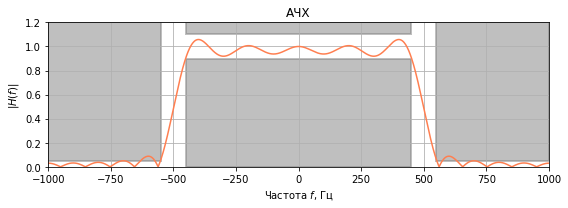

In [9]:
M=1024
H1=abs(np.fft.fftshift(np.fft.fft(h, M)))
plt.figure(figsize=[8, 3])
plt.plot(fs*(np.arange(M)/M-0.5), H1, color='coral')
plt.grid()
plt.ylabel('$|H(f)|$')
plt.xlabel('Частота $f$, Гц')
plt.title('АЧХ')
plt.xlim([-fs/2, fs/2])
plt.ylim([0.0, 1.2])
plt.fill([-f1,-f1, f1, f1], [0, 1-delta1, 1-delta1, 0], color='gray', lw=2, alpha=0.5)
plt.fill([-fs/2,-fs/2, -f2, -f2], [delta2, 1.2, 1.2, delta2], color='gray', lw=2, alpha=0.5)
plt.fill([f2,f2, fs/2, fs/2], [delta2, 1.2, 1.2, delta2], color='gray', lw=2, alpha=0.5)
plt.fill([-f1,-f1, f1, f1], [1+delta1, 1.2, 1.2, 1+delta1], color='gray', lw=2, alpha=0.5)
plt.tight_layout()
plt.show()

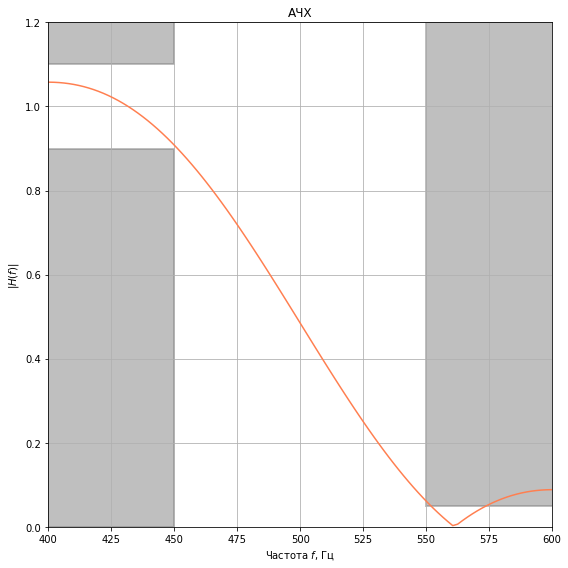

In [10]:
M=1024
plt.figure(figsize=[8, 8])
plt.plot(fs*(np.arange(M)/M-0.5), H1, color='coral')
plt.grid()
plt.ylabel('$|H(f)|$')
plt.xlabel('Частота $f$, Гц')
plt.title('АЧХ')
plt.xlim([-fs/2, fs/2])
plt.ylim([0.0, 1.2])
plt.fill([-f1,-f1, f1, f1], [0, 1-delta1, 1-delta1, 0], color='gray', lw=2, alpha=0.5)
plt.fill([-fs/2,-fs/2, -f2, -f2], [delta2, 1.2, 1.2, delta2], color='gray', lw=2, alpha=0.5)
plt.fill([f2,f2, fs/2, fs/2], [delta2, 1.2, 1.2, delta2], color='gray', lw=2, alpha=0.5)
plt.fill([-f1,-f1, f1, f1], [1+delta1, 1.2, 1.2, 1+delta1], color='gray', lw=2, alpha=0.5)
plt.xlim([400, 600])
plt.tight_layout()
plt.show()

## Основные оконные функции 
### Формулы оконных функций

Прямоугольное окно (Дирихле)
$$w[k]=\left\{ \begin{matrix}
   1,  \\
   0,  \\
\end{matrix}\begin{matrix}
   \ \ 0\le k\le N-1;  \\
   \left\{ k<0 \right\}\cup \left\{ k\ge N \right\}.  \\
\end{matrix} \right.$$

Окно Ханна 
$$w[k]=\left\{ \begin{matrix}
   0,5-0,5\cos \dfrac{2\pi k}{N-1},  \\
   0,  \\
\end{matrix}\begin{matrix}
   \ \ 0\le k\le N-1;  \\
   \left\{ k<0 \right\}\cup \left\{ k\ge N \right\}.  \\
\end{matrix} \right.$$

Окно Хэмминга
$$w[k]=\left\{ \begin{matrix}
   0,54-0,46\cos \dfrac{2\pi k}{N-1},  \\
   0,  \\
\end{matrix}\begin{matrix}
   \ \ 0\le k\le N-1;  \\
   \left\{ k<0 \right\}\cup \left\{ k\ge N \right\}.  \\
\end{matrix} \right.$$

Окно Блэкмана
$$w[k]=\left\{ \begin{matrix}
   0,42-0,5\cos \dfrac{2\pi k}{N-1}+0,08\cos \dfrac{4\pi k}{N-1},\ \   \\
   0,  \\
\end{matrix}\begin{matrix}
   \ \ 0\le k\le N-1;  \\
   \left\{ k<0 \right\}\cup \left\{ k\ge N \right\}.  \\
\end{matrix} \right.$$

**Примечание 1.** Для синтеза КИХ-фильтров используются симметричные окна, которые позволяют получить КИХ-фильтры с линейной фазовой характеристикой типов 1 и 2. В итоге окна Ханна, Хэмминга и Блэкмана отличаются от окон для ДПФ, рассмотреных на лекции, где были рассмотрены окна для спектрального анализа (знаменатели дробей $N-1$ вместо $N$).

**Примечание 2.** Окно Ханна названо в честь метеоролога Julius Ferdinand von Hann, использовавшего метод, основанный на взвешивании, для сглаживания метеорологических данных. В работах Блэкмана и Тьюки фраза "hanning a signal" означала взвешивание сигнала оконом Ханна. Из-за этого его часто ошибочно называют окном Хеннига. Функция `signal.windows.hanning` работает с предупреждением. 

In [11]:
signal.windows.hanning(M=20, sym=True)

C:\Users\torma\AppData\Local\Temp/ipykernel_10688/3317945666.py:1: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  signal.windows.hanning(M=20, sym=True)


array([0.        , 0.02709138, 0.10542975, 0.22652592, 0.37725726,
       0.54128967, 0.70084771, 0.83864079, 0.93973688, 0.99318065,
       0.99318065, 0.93973688, 0.83864079, 0.70084771, 0.54128967,
       0.37725726, 0.22652592, 0.10542975, 0.02709138, 0.        ])

### Модуль scipy.signal.windows
https://docs.scipy.org/doc/scipy/reference/signal.windows.html

scipy.signal.windows.hann(M, sym=True)

* ``M`` – длина окна
* ``sym`` — параметр, который определяет вид окна:

* * ``sym=True`` — синтез симметричного окна для синтеза КИХ-фильтров,

* * ``sym=False`` — синтез окна для ДПФ, используемого для спектрального анализа. 

In [12]:
w=signal.windows.hann(M=20, sym=True)
w

array([0.        , 0.02709138, 0.10542975, 0.22652592, 0.37725726,
       0.54128967, 0.70084771, 0.83864079, 0.93973688, 0.99318065,
       0.99318065, 0.93973688, 0.83864079, 0.70084771, 0.54128967,
       0.37725726, 0.22652592, 0.10542975, 0.02709138, 0.        ])

In [13]:
M=20
k=np.arange(M)
0.5*np.ones(M)-0.5*np.cos(2*np.pi*k/(M-1))

array([0.        , 0.02709138, 0.10542975, 0.22652592, 0.37725726,
       0.54128967, 0.70084771, 0.83864079, 0.93973688, 0.99318065,
       0.99318065, 0.93973688, 0.83864079, 0.70084771, 0.54128967,
       0.37725726, 0.22652592, 0.10542975, 0.02709138, 0.        ])

array([ 3.42868055e-02, -1.88951520e-17, -4.40830357e-02,  1.88951520e-17,
        6.17162500e-02, -1.88951520e-17, -1.02860417e-01,  1.88951520e-17,
        3.08581250e-01,  4.84718294e-01,  3.08581250e-01,  1.88951520e-17,
       -1.02860417e-01, -1.88951520e-17,  6.17162500e-02,  1.88951520e-17,
       -4.40830357e-02, -1.88951520e-17,  3.42868055e-02])

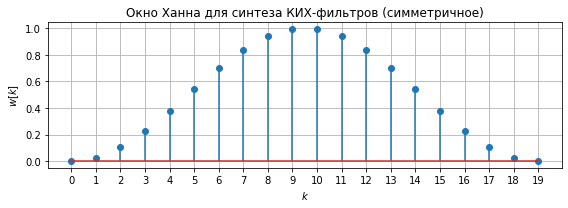

In [14]:
plt.figure(figsize=[8, 3])
plt.stem(np.arange(w.size),w)
plt.grid()
plt.xlabel('$k$')
plt.ylabel('$w[k]$')
plt.title("Окно Ханна для синтеза КИХ-фильтров (симметричное)")
plt.xticks(k)
plt.tight_layout()
h

array([0.        , 0.02447174, 0.0954915 , 0.20610737, 0.3454915 ,
       0.5       , 0.6545085 , 0.79389263, 0.9045085 , 0.97552826,
       1.        , 0.97552826, 0.9045085 , 0.79389263, 0.6545085 ,
       0.5       , 0.3454915 , 0.20610737, 0.0954915 , 0.02447174])

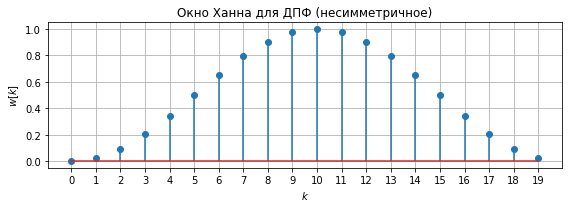

In [15]:
h=signal.windows.hann(M=20, sym=False)
plt.figure(figsize=[8, 3])
plt.stem(np.arange(h.size),h)
plt.grid()
plt.xlabel('$k$')
plt.ylabel('$w[k]$')
plt.title("Окно Ханна для ДПФ (несимметричное)")
plt.xticks(k)
plt.tight_layout()
h

## Итерационная процедура синтеза КИХ-фильтров

1) Выбрать начальный порядок фильтра $R$.

2) Cинтезировать КИХ-фильтр порядка $R$ выбранным методом.

3) Проверить выполнение требований к АЧХ фильтра. 
* Если требования не выпоняются, следует увеличить порядок фильтра $R$ (на некоторое целое число) и перейти на п. 2.
* Если требования выполняются, то нужно уменьшить порядок фильтра  $R$ и перейти на п. 2. 
* Уменьшение и увеличение порядка производится до тех пор, пока не будет найден минимальный порядок , при котором выполняются требования к АЧХ и уменьшение порядка на единицу приводит к нарушению требований к фильтру. 

Процедура подходит для синтеза КИХ-фильтров методами наименьших квадратов и равномерной Чебышёвской аппроксимации, а также оконным методом (кроме окна Кайзера). 

## Окно Кайзера

Джеймс Кайзер (1929-2020, Лаборатории Белла, MIT) предложил использовать окна следующего вида


Окно Кайзера
$$w[k]=\left\{ \begin{matrix}
   \dfrac{{{I}_{0}}\left( \beta \sqrt{1-{{\left( \dfrac{2k}{N-1} \right)}^{2}}} \right)}{{{I}_{0}}(\beta )}, & \ \ 0\le k\le N-1;  \\
   0 & \left\{ k<0 \right\}\cup \left\{ k\ge N \right\}.  \\
\end{matrix} \right.$$
где 
* $N$ — длина окна, порядок фильтра $R=N-1$  определяют по эмпирической формуле 
$$R=\left[ \dfrac{{{a}_{\min }}-7,95}{2,285\Delta \theta } \right], $$ где
* * ${{a}_{\min }}$– минимальное заданное затухание КИХ-фильтра в дБ,
* * $\Delta \theta $ - ширина полосы перехода.
* $I_0 (x)$ — модифицированная функция Бесселя первого рода нулевого порядка, которая может быть вычислена с помощью быстро сходящегося степенного ряда (обычно достаточно $L<25$)
$${{I}_{0}}(x)=1+\underset{m=1}{\overset{L}{\mathop \sum }}\,{{\left( \frac{{{\left( x/2 \right)}^{m}}}{m!} \right)}^{2}}$$
* $\beta$ — параметр окна Кайзера, определяемой по эмпирической формуле




$$\beta=\left\{ \begin{matrix}
   0,1102({{a}_{\min }}-8,7), & {{a}_{\min }}>50;  \\
   0.5842{{({{a}_{\min }}-21)}^{0.4}}+0.07886({{a}_{\min }}-21), & 21\le {{a}_{\min }}\le 50;  \\
   0 & {{a}_{\min }}<21.  \\
\end{matrix} \right.$$



In [16]:
20*np.log10(0.05)

-26.020599913279625

In [17]:
beta = signal.kaiser_beta(a=-20*np.log10(0.05))
beta

1.509869637041394

Функция `signal.kaiserord` определяет $\beta$ и длину окна $N$ по приведенным выше эмпирическим формулам. Параметры функции следующие. 
* `width` - ширина полосы перехода фильтра в долях частоты Найквиста ($\Delta f / (f_д/2)$)
* `ripple` - уровень пульсаций АЧХ относительно АЧХ идеального фильтра в дБ (положительное число). Для оконного метода синтеза КИХ-фильтров пульсации АЧХ в полосе пропускания и в полосе задерживания фильтра получаются примерно одинаковыми, поэтому это значение определяется наиболее строгим требованием.

In [18]:
N, beta=signal.kaiserord(ripple=-20*np.log10(0.05), width=(f2-f1)/(fs/2))
N

27

In [19]:
R=N-1
R

26

In [20]:
beta

1.509869637041394

<IPython.core.display.Javascript object>


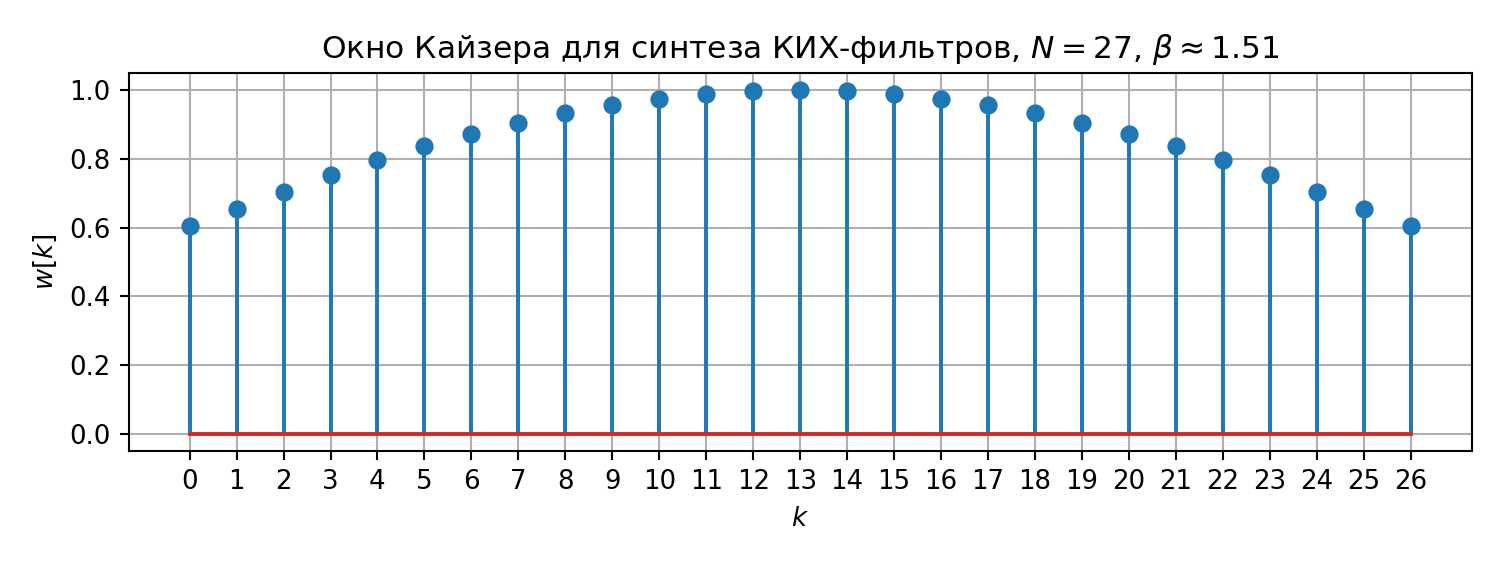

array([0.        , 0.02447174, 0.0954915 , 0.20610737, 0.3454915 ,
       0.5       , 0.6545085 , 0.79389263, 0.9045085 , 0.97552826,
       1.        , 0.97552826, 0.9045085 , 0.79389263, 0.6545085 ,
       0.5       , 0.3454915 , 0.20610737, 0.0954915 , 0.02447174])

In [122]:
w=signal.windows.kaiser(M=R+1, beta=beta, sym=True)
plt.figure(figsize=[8, 3])
plt.stem(np.arange(w.size), w, use_line_collection=True)
plt.grid()
plt.xlabel('$k$')
plt.ylabel('$w[k]$')
plt.title("Окно Кайзера для синтеза КИХ-фильтров, $N=$%i, $\\beta \\approx $%.2f" %(N, beta))
plt.xticks(np.arange(w.size))
plt.tight_layout()
h

In [123]:
cutoff=(f1+f2)/2 # 500
N=R+1
h = signal.firwin(numtaps=N, cutoff=cutoff, window=('kaiser', beta), pass_zero='lowpass', fs=fs)

<IPython.core.display.Javascript object>


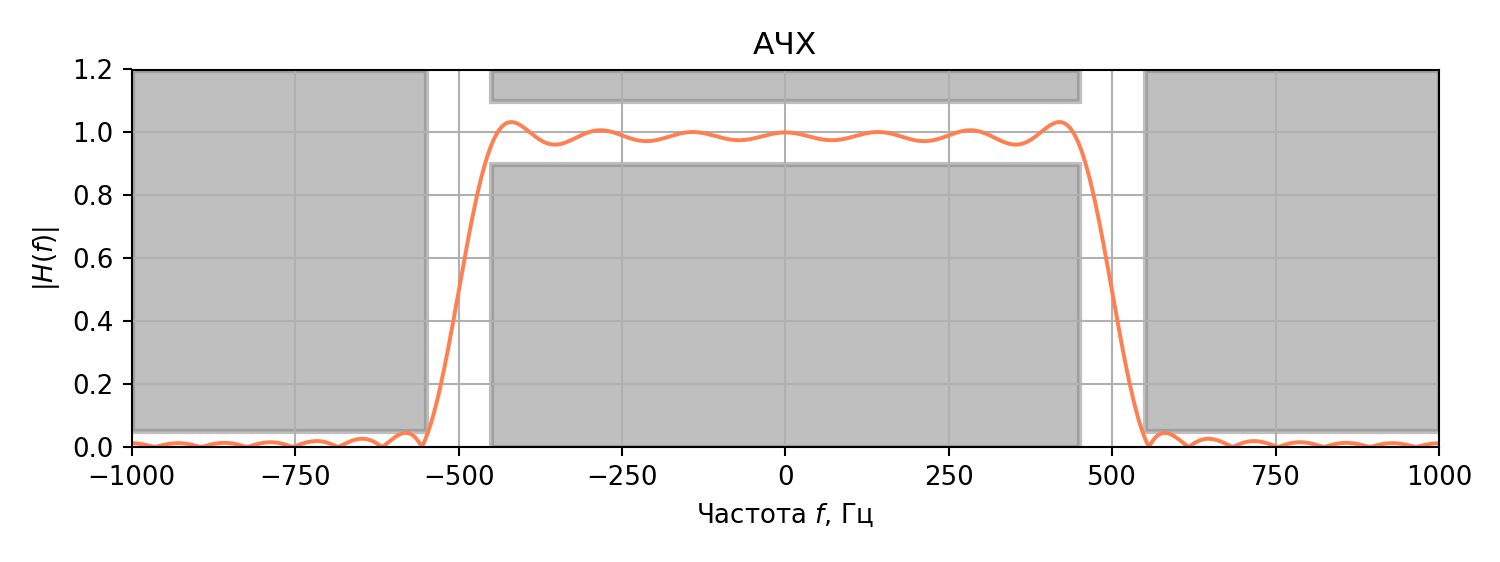

In [124]:
M=1024
H1=abs(np.fft.fftshift(np.fft.fft(h, M)))
plt.figure(figsize=[8, 3])
plt.plot(fs*(np.arange(M)/M-0.5), H1, color='coral')
plt.grid()
plt.ylabel('$|H(f)|$')
plt.xlabel('Частота $f$, Гц')
plt.title('АЧХ')
plt.xlim([-fs/2, fs/2])
plt.ylim([0.0, 1.2])
plt.fill([-f1,-f1, f1, f1], [0, 1-delta1, 1-delta1, 0], color='gray', lw=2, alpha=0.5)
plt.fill([-fs/2,-fs/2, -f2, -f2], [delta2, 1.2, 1.2, delta2], color='gray', lw=2, alpha=0.5)
plt.fill([f2,f2, fs/2, fs/2], [delta2, 1.2, 1.2, delta2], color='gray', lw=2, alpha=0.5)
plt.fill([-f1,-f1, f1, f1], [1+delta1, 1.2, 1.2, 1+delta1], color='gray', lw=2, alpha=0.5)
plt.tight_layout()
plt.show()

## Комбинация метода частотной выборки с оконным (`scipy.signal.firwin2`)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html


In [128]:
freq=np.array([0, f1, f2, fs/2])
gain=np.array([1, 1, 0, 0])
nfreqs=2**14
N=21
h_firwin2=signal.firwin2(numtaps=N, freq=freq, gain=gain, nfreqs=nfreqs, window='hamming', antisymmetric=False, fs=fs)


In [130]:
h_firwin2=signal.firwin2(numtaps=N, freq=freq, gain=gain, nfreqs=nfreqs, window='boxcar', antisymmetric=False, fs=fs)

<IPython.core.display.Javascript object>


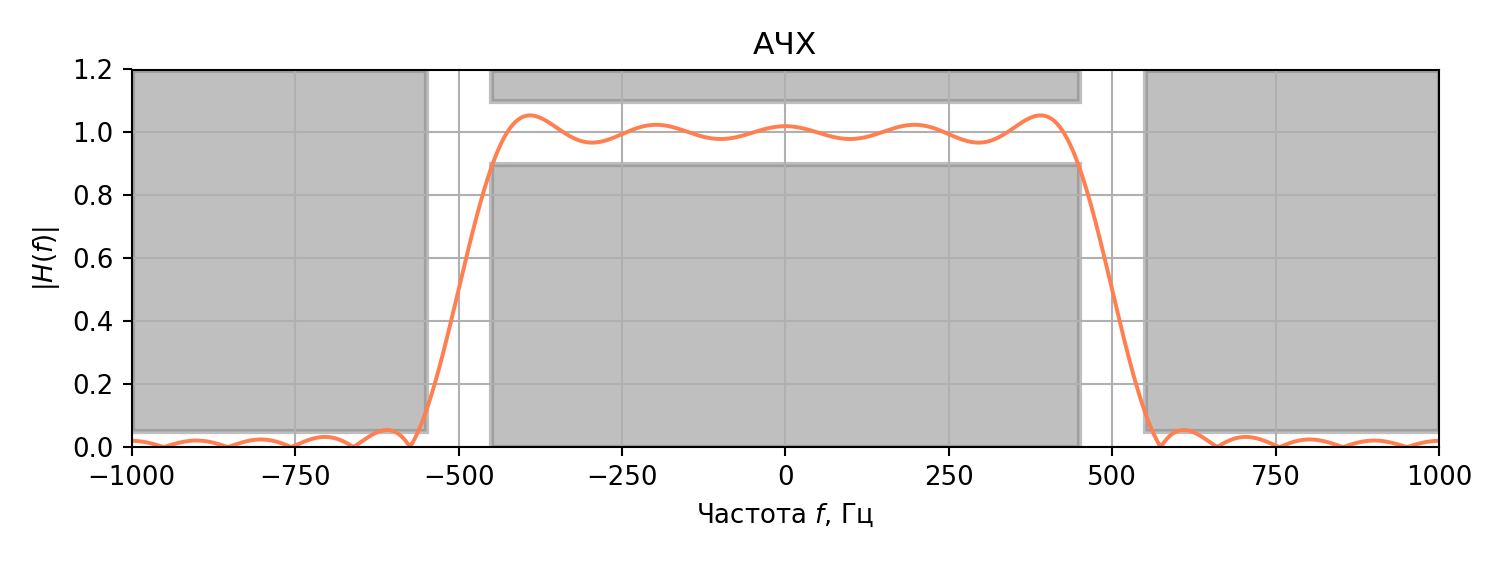

In [131]:
M=1024
H1=abs(np.fft.fftshift(np.fft.fft(h_firwin2, M)))
plt.figure(figsize=[8, 3])
plt.plot(fs*(np.arange(M)/M-0.5), H1, color='coral')
plt.grid()
plt.ylabel('$|H(f)|$')
plt.xlabel('Частота $f$, Гц')
plt.title('АЧХ')
plt.xlim([-fs/2, fs/2])
plt.ylim([0.0, 1.2])
plt.fill([-f1,-f1, f1, f1], [0, 1-delta1, 1-delta1, 0], color='gray', lw=2, alpha=0.5)
plt.fill([-fs/2,-fs/2, -f2, -f2], [delta2, 1.2, 1.2, delta2], color='gray', lw=2, alpha=0.5)
plt.fill([f2,f2, fs/2, fs/2], [delta2, 1.2, 1.2, delta2], color='gray', lw=2, alpha=0.5)
plt.fill([-f1,-f1, f1, f1], [1+delta1, 1.2, 1.2, 1+delta1], color='gray', lw=2, alpha=0.5)
plt.tight_layout()
plt.show()

## Рекомендуемая литература 
* Солонина, А. И. Цифровая обработка сигналов в зеркале MATLAB : учебное пособие / А. И. Солонина .— Санкт-Петербург : БХВ-Петербург, 2021 .— 560 с. — (Учебная литература для вузов).
* Васильев, В. П. Основы теории и расчета цифровых фильтров : учебное пособие / В. П. Васильев, Э. Л. Муро, С. М. Смольский ; под ред. С. М. Смольского .— 2-е изд., стереотип. — Москва : ИНФРА-М, 2020 .— 272 с.